In [1]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
import data_processing as dp

#img_size = 96
#color_mode = 'rgb'
#max_image_per_class = 1000

#(X_train, X_test, y_train, y_test), reverse_map = dp.load_asl_alphabet_dataset(96, 'rgb', 1000)

import data_processing as dp
(X_train, y_train), (X_val, y_val), (X_test, y_test), reverse_map = dp.load_asl_alphabet_dataset1(
    img_size=96,
    color_mode='rgb',
    max_image_per_class = 1000
)

print(f"Train shape: {X_train.shape}, Validation shape: {X_val.shape}, Test shape: {X_test.shape}")

Train shape: (20300, 96, 96, 3), Validation shape: (5800, 96, 96, 3), Test shape: (2900, 96, 96, 3)


In [3]:
import os

data_train_dir = "./data/asl_alphabet_train"

def count_images_per_class(data_dir):
    class_counts = {}
    for label in os.listdir(data_dir):
        folder_path = os.path.join(data_dir, label)
        if os.path.isdir(folder_path):
            num_images = len([
                f for f in os.listdir(folder_path)
                if f.lower().endswith(('.jpg', '.jpeg', '.png'))
            ])
            class_counts[label] = num_images
    
    return class_counts

# Get counts
class_counts = count_images_per_class(data_train_dir)

# Display
for label, count in class_counts.items():
    print(f"{label}: {count} images")

# Optional: Total images
total = sum(class_counts.values())
#print(f"Total images: {total}")

R: 3000 images
U: 3000 images
I: 3000 images
N: 3000 images
G: 3000 images
Z: 3000 images
T: 3000 images
S: 3000 images
A: 3000 images
F: 3000 images
O: 3000 images
H: 3000 images
del: 3000 images
nothing: 3000 images
space: 3000 images
M: 3000 images
J: 3000 images
C: 3000 images
D: 3000 images
V: 3000 images
Q: 3000 images
X: 3000 images
E: 3000 images
B: 3000 images
K: 3000 images
L: 3000 images
Y: 3000 images
P: 3000 images
W: 3000 images


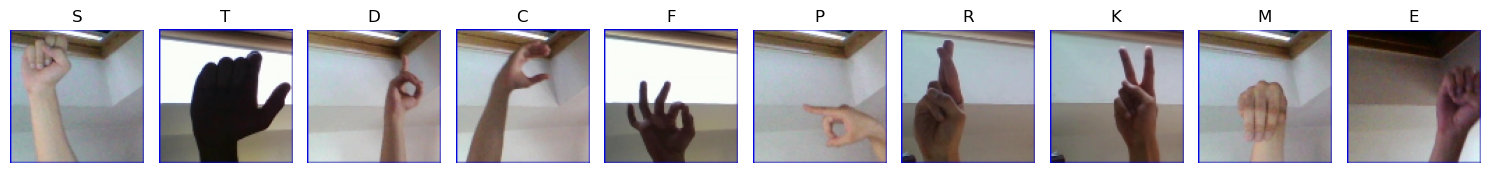

In [4]:
import matplotlib.pyplot as plt

def show_samples(X, y, reverse_map, num_samples):
    plt.figure(figsize=(15, 3))
    for i in range(num_samples):
        plt.subplot(1, num_samples, i + 1)
        
        img = X[i]
        
        # If grayscale (has shape (H, W, 1)), squeeze last dim
        if img.shape[-1] == 1:
            img = img.reshape(img.shape[0], img.shape[1])
            plt.imshow(img, cmap='gray')
        else:
            plt.imshow(img)
        
        plt.title(reverse_map[y[i]])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

show_samples(X_train, y_train, reverse_map, num_samples = 10)

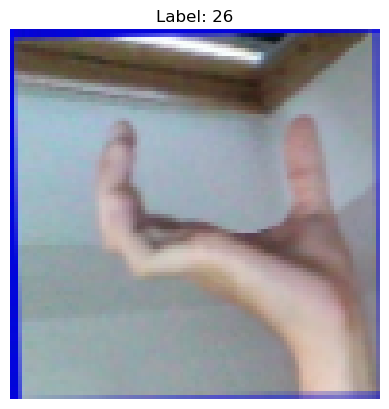

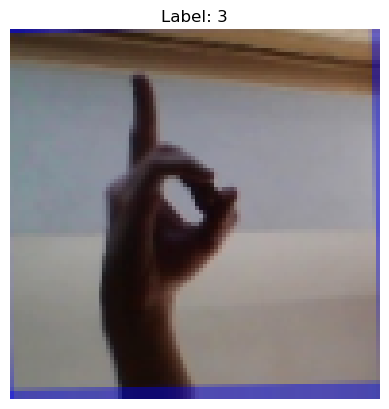

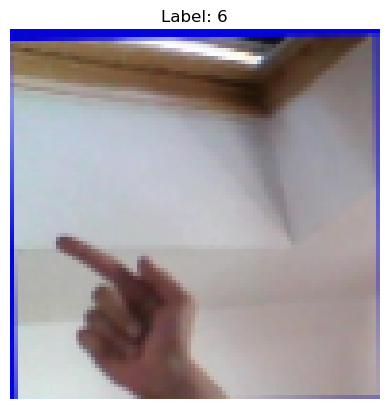

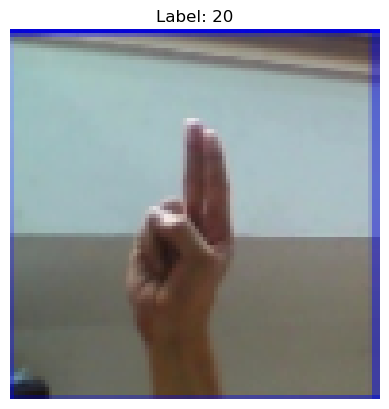

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define your image data generator
datagen = ImageDataGenerator(
    rotation_range=2,
    width_shift_range=0.02,
    height_shift_range=0.02,
    zoom_range=0.02
)

for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=4):
    for i in range(4):
        plt.imshow(X_batch[i].astype(np.float32))
        plt.title(f"Label: {y_batch[i]}")
        plt.axis("off")
        plt.show()
    break

In [6]:
num_classes = 29

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False  # start frozen

model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),  
    layers.Dense(64, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.4),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    optimizer=Adam(learning_rate=3e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

#from tensorflow.keras.utils import plot_model

# Save architecture diagram as a PNG
#plot_model(model, to_file="asl_cnn_architecture.png", show_shapes=True, show_layer_names=True)

model.summary()

2025-07-28 22:26:42.548934: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-07-28 22:26:42.549159: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-07-28 22:26:42.549526: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-07-28 22:26:42.549578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-07-28 22:26:42.549943: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 3, 3, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 29)             │         1,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,749,661 (56.27 MB)

 Trainable params: 34,845 (136.11 KB)

 Non-trainable params: 14,714,816 (56.13 MB)

In [7]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint("./model/vgg16.keras", save_best_only=True)
]

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val, y_val),
    epochs=10,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/10


/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
2025-07-28 22:26:43.673637: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-07-28 22:26:43.677626: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


635/635 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.1809 - loss: 3.0677

2025-07-28 22:27:52.877810: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] PluggableGraphOptimizer failed: INVALID_ARGUMENT: Failed to deserialize the `graph_buf`.


635/635 ━━━━━━━━━━━━━━━━━━━━ 88s 137ms/step - accuracy: 0.1811 - loss: 3.0669 - val_accuracy: 0.6183 - val_loss: 1.6230
Epoch 2/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 85s 134ms/step - accuracy: 0.5746 - loss: 1.5885 - val_accuracy: 0.7757 - val_loss: 0.9740
Epoch 3/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 86s 136ms/step - accuracy: 0.7007 - loss: 1.1138 - val_accuracy: 0.8509 - val_loss: 0.6755
Epoch 4/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 87s 137ms/step - accuracy: 0.7684 - loss: 0.8566 - val_accuracy: 0.8671 - val_loss: 0.5422
Epoch 5/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 86s 136ms/step - accuracy: 0.7936 - loss: 0.7227 - val_accuracy: 0.8869 - val_loss: 0.4305
Epoch 6/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 86s 135ms/step - accuracy: 0.8261 - loss: 0.6065 - val_accuracy: 0.9112 - val_loss: 0.3504
Epoch 7/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 86s 136ms/step - accuracy: 0.8327 - loss: 0.5595 - val_accuracy: 0.9072 - val_loss: 0.3262
Epoch 8/10
635/635 ━━━━━━━━━━━━━━━━━━━━ 86s 135ms/step - accuracy: 0.8525 - loss: 0.5041 - val

In [8]:
test_loss, test_acc = model.evaluate(X_val, y_val, verbose=1)
print(f"Validation Accuracy: {test_acc:.4f}")

182/182 ━━━━━━━━━━━━━━━━━━━━ 19s 102ms/step - accuracy: 0.9244 - loss: 0.2481
Validation Accuracy: 0.9300


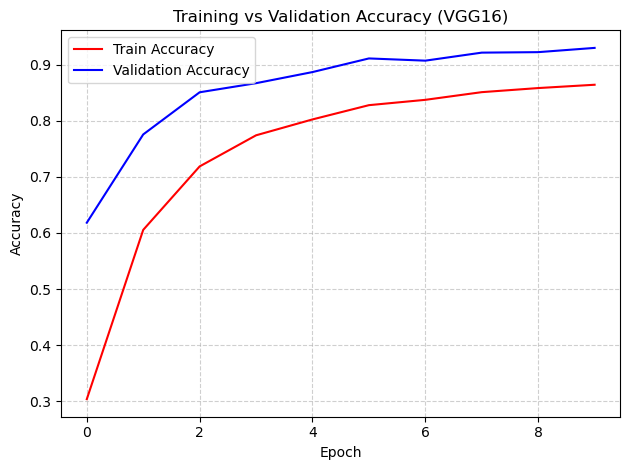

In [9]:

plt.plot(history.history['accuracy'], label='Train Accuracy', color='red')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='blue')

plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training vs Validation Accuracy (VGG16)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

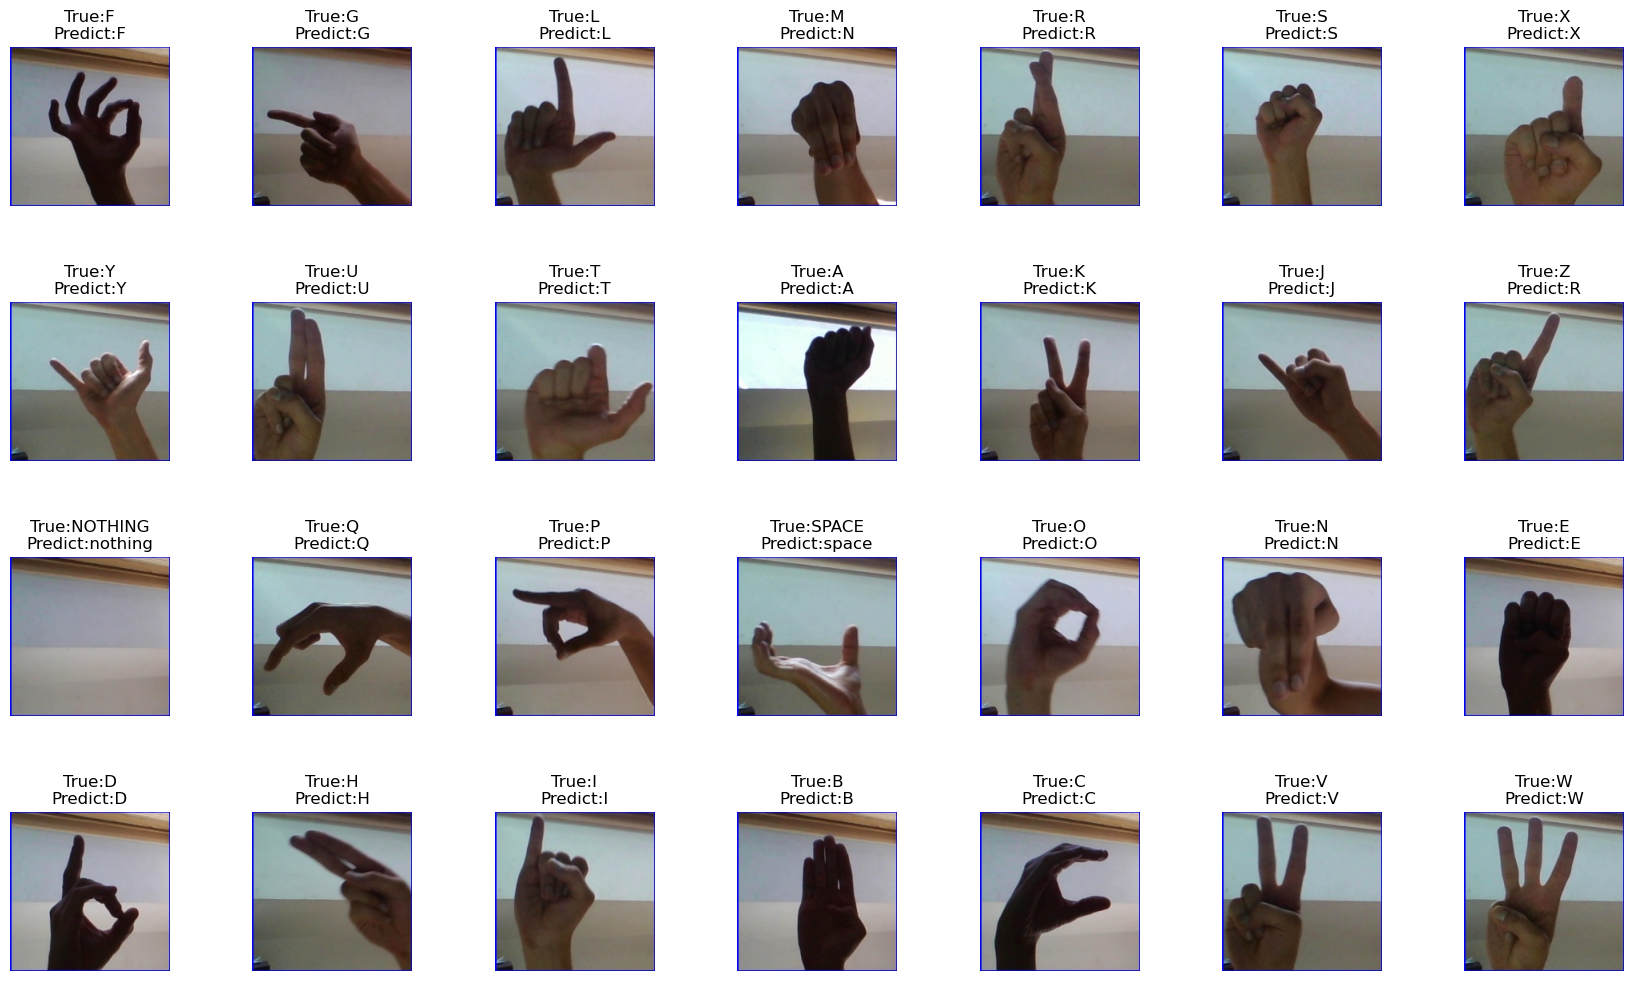

In [12]:
import math
def evaluate_on_test_folder(model, test_dir, img_size, reverse_map, N=None):
    results = []
    
    all_files = [
        (os.path.splitext(f)[0].split("_")[0].strip().upper(), os.path.join(test_dir, f))
        for f in os.listdir(test_dir)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    
    if N:
        all_files = all_files[:N]
    
    for true_label, img_path in all_files:
        img = cv2.imread(img_path, cv2.IMREAD_COLOR)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (img_size, img_size)).astype("float32") / 255.0
        img_input = img.reshape(1, img_size, img_size, 3)
        
        pred = model.predict(img_input, verbose=0)
        pred_class = np.argmax(pred)
        pred_label = reverse_map[pred_class]
        
        results.append({
            "True Label": true_label,
            "Predicted Label": pred_label
        })
    
    # Display grid
    images_per_row = 7
    num_images = len(results)
    num_rows = math.ceil(num_images / images_per_row)
    
    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(3 * images_per_row, 3 * num_rows))
    axes = axes.flatten()

    for i in range(len(axes)):
        ax = axes[i]
        if i < num_images:
            img_disp = cv2.imread(all_files[i][1])
            img_disp = cv2.cvtColor(img_disp, cv2.COLOR_BGR2RGB)
            ax.imshow(img_disp)
            ax.set_title(f"True:{results[i]['True Label']}\nPredict:{results[i]['Predicted Label']}", fontsize=12)
        ax.axis('off')
    
    plt.subplots_adjust(wspace=0.4, hspace=0.6)  # 👈 Adds gaps between columns (wspace) and rows (hspace)
    plt.show()

    return results

test_dir = "./data/asl_alphabet_test"  
results = evaluate_on_test_folder(model, test_dir, img_size=96, reverse_map=reverse_map)

In [13]:
# Compute accuracy
correct = sum(1 for r in results if r["True Label"] == r["Predicted Label"])
accuracy = correct / len(results) if results else 0
print(f"VGG16 : Test accuracy: {accuracy:.4f}")

VGG16 : Test accuracy: 0.8571


In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd

# Predict labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# Binary: 1 if prediction is correct, 0 if incorrect
y_true_binary = (y_pred == y_test).astype(int)
y_pred_binary = np.ones_like(y_true_binary)  # pretend all predictions are "True" to align with comparison

# Now confusion matrix for correct vs incorrect predictions
cm_binary = confusion_matrix(y_true_binary, y_pred_binary)

# Format as 2x2 table
cm_df = pd.DataFrame(cm_binary,
                     index=["Actually Incorrect", "Actually Correct"],
                     columns=["Predicted Incorrect", "Predicted Correct"])

print("Confusion Matrix:")
display(cm_df)

91/91 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step
Confusion Matrix:


,Predicted Incorrect,Predicted Correct
Actually Incorrect,0,205
Actually Correct,0,2695


In [16]:
from sklearn.metrics import classification_report, f1_score

# Print precision, recall, f1-score for each class
print(classification_report(y_test, y_pred, digits=4))

# Optional: get macro/micro F1 score only
f1_macro = f1_score(y_test, y_pred, average='macro')
f1_micro = f1_score(y_test, y_pred, average='micro')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print(f"F1 Macro:    {f1_macro:.4f}")
print(f"F1 Micro:    {f1_micro:.4f}")
print(f"F1 Weighted: {f1_weighted:.4f}")

              precision    recall  f1-score   support

           0     0.8469    0.9765    0.9071        85
           1     0.8393    0.9895    0.9082        95
           2     1.0000    0.9800    0.9899       100
           3     1.0000    0.9528    0.9758       106
           4     0.9787    0.8762    0.9246       105
           5     1.0000    0.9811    0.9905       106
           6     1.0000    0.8804    0.9364        92
           7     0.9533    0.9808    0.9668       104
           8     0.9684    0.8846    0.9246       104
           9     0.9182    0.9902    0.9528       102
          10     1.0000    0.9159    0.9561       107
          11     0.9828    1.0000    0.9913       114
          12     0.9831    0.5472    0.7030       106
          13     0.6081    0.9677    0.7469        93
          14     0.9238    0.9510    0.9372       102
          15     0.9811    1.0000    0.9905       104
          16     0.9906    0.9906    0.9906       106
          17     0.9865    